In [1]:
import netCDF4 as nc
from matplotlib import pyplot as plt
import numpy as np
import glob
import pickle
from salishsea_tools import evaltools as et
import datetime as dt
import os
import re
import cmocean
%matplotlib inline

In [2]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=mesh.variables['tmask'][0,:,:,:]
    e1t=np.expand_dims(mesh.variables['e1t'][:,:,:],1)
    e2t=np.expand_dims(mesh.variables['e2t'][:,:,:],1)
SOGtmaskPath='/ocean/eolson/MEOPAR/northernNO3PaperCalcs/save/SOGtmask.pkl'
(tmaskSOG,_,_,_,_)=pickle.load(open(SOGtmaskPath,'rb'))

In [3]:
idir='/data/sallen/results/MEOPAR/fluxes/'
ts=dt.datetime(2015,1,1)
te=dt.datetime(2015,12,31)

In [4]:
fPlist=et.index_model_files_flex(idir,'dian_T',ts,te)

In [5]:
fPlist.head()

,paths,t_0,t_n
0,/data/sallen/results/MEOPAR/fluxes/01jan15/Sal...,2015-01-01,2015-01-06
1,/data/sallen/results/MEOPAR/fluxes/06jan15/Sal...,2015-01-06,2015-01-11
2,/data/sallen/results/MEOPAR/fluxes/11jan15/Sal...,2015-01-11,2015-01-16
3,/data/sallen/results/MEOPAR/fluxes/16jan15/Sal...,2015-01-16,2015-01-21
4,/data/sallen/results/MEOPAR/fluxes/21jan15/Sal...,2015-01-21,2015-01-26


In [6]:
physSum=list();bioSum=list();allSum=list();rivSum=list();afiltSum=list();no3Sum=list();nitrSum=list();PPSum=list()
radSum=list();
for i,r in fPlist.iterrows():
    with nc.Dataset(r['paths']) as fP:
        physSum.append(np.sum(np.sum(np.sum(tmaskSOG*fP.variables['PHYSTRNO3'][:,:,:,:],3),2),1))
        bioSum.append(np.sum(np.sum(np.sum(tmaskSOG*fP.variables['BIOTRNO3'][:,:,:,:],3),2),1))
        allSum.append(np.sum(np.sum(np.sum(tmaskSOG*fP.variables['ALLTRNO3'][:,:,:,:],3),2),1))
        rivSum.append(np.sum(np.sum(np.sum(tmaskSOG*fP.variables['RIVNO3'][:,:,:,:],3),2),1))
        afiltSum.append(np.sum(np.sum(np.sum(tmaskSOG*fP.variables['AFILTNO3'][:,:,:,:],3),2),1))
        no3Sum.append(np.sum(np.sum(np.sum(tmaskSOG*e1t*e2t*fP.variables['NO3_E3TSNAP'][:,:,:,:],3),2),1))
        nitrSum.append(np.sum(np.sum(np.sum(tmaskSOG*fP.variables['NITR'][:,:,:,:],3),2),1))
        radSum.append(np.sum(np.sum(np.sum(tmaskSOG*fP.variables['NO3RAD'][:,:,:,:],3),2),1))
        PPSum.append(np.sum(np.sum(np.sum(tmaskSOG*(fP.variables['PPDIATNO3V'][:,:,:,:]+\
                                             fP.variables['PPPHYNO3V'][:,:,:,:]+\
                                             fP.variables['PPMRUBNO3V'][:,:,:,:]),3),2),1))
physSum=np.concatenate(physSum,axis=0)
bioSum=np.concatenate(bioSum,axis=0)
allSum=np.concatenate(allSum,axis=0)
rivSum=np.concatenate(rivSum,axis=0)
afiltSum=np.concatenate(afiltSum,axis=0)
no3Sum=np.concatenate(no3Sum,axis=0)
nitrSum=np.concatenate(nitrSum,axis=0)
PPSum=np.concatenate(PPSum,axis=0)

0.11112090812641152 11.590549327243934 0.9999998533446007 0.0 3.1586866387517015e-06


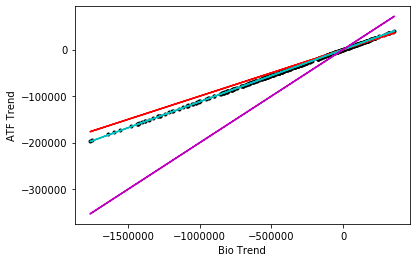

In [7]:
plt.plot(bioSum,afiltSum,'k.',label='ATF trend')
plt.plot(bioSum,0.1*bioSum,'r-', label='Bio trend * 0.1')
plt.plot(bioSum,0.112*bioSum,'c-', label='Bio trend * 0.112')
plt.plot(bioSum,0.2*bioSum,'m-', label='Bio trend * 0.2')
plt.xlabel('Bio Trend')
plt.ylabel('ATF Trend')
from scipy import stats as scst
slope, intercept, r_value, p_value, std_err = scst.linregress(bioSum,afiltSum)
print(slope, intercept, r_value, p_value, std_err)

In [8]:
radSum=np.concatenate(radSum,axis=0)

In [9]:
no3diff=(no3Sum[1:]-no3Sum[:-1])/(24*3600)

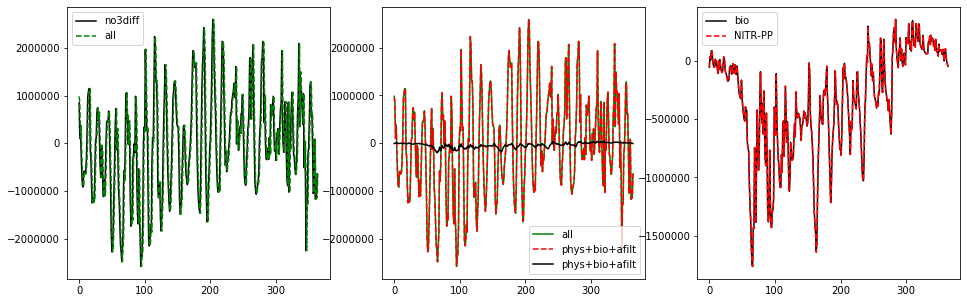

In [10]:
fig,ax=plt.subplots(1,3,figsize=(16,5))
ax[0].plot(range(0,len(no3diff)),no3diff,'k-',label='no3diff')
ax[0].plot(range(0,len(allSum)),allSum,'g--',label='all')
#ax[0].plot(range(0,5),afiltSum,'b--',label='afilt')
ax[0].legend()
ax[1].plot(range(0,len(allSum)),allSum,'g-',label='all')
ax[1].plot(range(0,len(allSum)),physSum+bioSum+afiltSum,'r--',label='phys+bio+afilt')
ax[1].plot(range(0,len(allSum)),afiltSum,'k-',label='phys+bio+afilt')
#ax[1].plot(range(0,5),bioSum,'k-',label='bio')
#ax[1].plot(range(0,5),nitrSum-PPSum,'r--',label='NITR-PP')
ax[1].legend()
ax[2].plot(range(0,len(allSum)),bioSum,'k-',label='bio')
ax[2].plot(range(0,len(allSum)),nitrSum-PPSum,'r--',label='NITR-PP')
ax[2].legend()

### Look at small differences in sums:

In [11]:
np.sum(radSum)

12.516972

In [12]:
# phys[trn*cvola-trb*cvolb] + bio[tra*cvol/rfac2] + afilt[(trb-trn)*cvol] - all
np.sum(physSum+bioSum+afiltSum)-np.sum(allSum),np.sum(allSum),np.sum(rivSum)

(145772.0, -3878092.0, 11269719.0)

In [13]:
flist=et.index_model_files_flex(idir,'Malaspina_U',ts,te)
malUA=list();malUD=list();
for i,r in flist.iterrows():
    with nc.Dataset(r['paths']) as f:
        malUA.append(np.sum(np.sum(f.variables['NO3TVDX'][:,:,:,0],2),1))
        malUD.append(np.sum(np.sum(f.variables['ULDFNO3'][:,:,:,0],2),1))
malUA=np.concatenate(malUA,axis=0)
malUD=np.concatenate(malUD,axis=0)

In [14]:
flist=et.index_model_files_flex(idir,'Haro_V',ts,te)
harVA=list();harVD=list();
for i,r in flist.iterrows():
    with nc.Dataset(r['paths']) as f:
        harVA.append(np.sum(np.sum(f.variables['NO3TVDY'][:,:,0,:],2),1))
        harVD.append(np.sum(np.sum(f.variables['VLDFNO3'][:,:,0,:],2),1))
harVA=np.concatenate(harVA,axis=0)
harVD=np.concatenate(harVD,axis=0)

In [15]:
flist=et.index_model_files_flex(idir,'SJC_V',ts,te)
sjcVA=list();sjcVD=list();
for i,r in flist.iterrows():
    with nc.Dataset(r['paths']) as f:
        sjcVA.append(np.sum(np.sum(f.variables['NO3TVDY'][:,:,0,:],2),1))
        sjcVD.append(np.sum(np.sum(f.variables['VLDFNO3'][:,:,0,:],2),1))
sjcVA=np.concatenate(sjcVA,axis=0)
sjcVD=np.concatenate(sjcVD,axis=0)

In [16]:
flist=et.index_model_files_flex(idir,'Rosario_V',ts,te)
rosVA=list();rosVD=list();
for i,r in flist.iterrows():
    with nc.Dataset(r['paths']) as f:
        rosVA.append(np.sum(np.sum(f.variables['NO3TVDY'][:,:,0,:],2),1))
        rosVD.append(np.sum(np.sum(f.variables['VLDFNO3'][:,:,0,:],2),1))
rosVA=np.concatenate(rosVA,axis=0)
rosVD=np.concatenate(rosVD,axis=0)

In [17]:
flist=et.index_model_files_flex(idir,'Sutil_V',ts,te)
sutVA=list();sutVD=list();
for i,r in flist.iterrows():
    with nc.Dataset(r['paths']) as f:
        sutVA.append(np.sum(np.sum(f.variables['NO3TVDY'][:,:,0,:],2),1))
        sutVD.append(np.sum(np.sum(f.variables['VLDFNO3'][:,:,0,:],2),1))
sutVA=np.concatenate(sutVA,axis=0)
sutVD=np.concatenate(sutVD,axis=0)

In [18]:
flist=et.index_model_files_flex(idir,'Discovery_V',ts,te)
disVA=list();disVD=list();
for i,r in flist.iterrows():
    with nc.Dataset(r['paths']) as f:
        disVA.append(np.sum(np.sum(f.variables['NO3TVDY'][:,:,0,:],2),1))
        disVD.append(np.sum(np.sum(f.variables['VLDFNO3'][:,:,0,:],2),1))
disVA=np.concatenate(disVA,axis=0)
disVD=np.concatenate(disVD,axis=0)

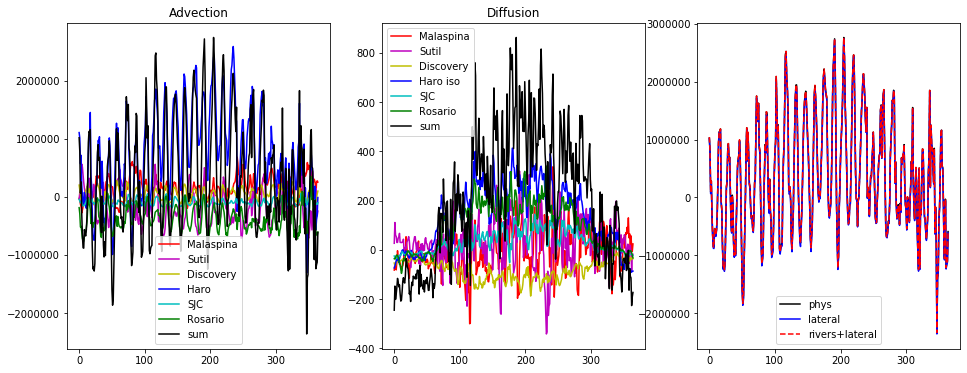

In [19]:
fig,ax=plt.subplots(1,3,figsize=(16,6))
ax[0].plot(range(0,len(malUA)),-1*malUA,'r-',label='Malaspina')
ax[0].plot(range(0,len(malUA)),-1*sutVA,'m-',label='Sutil')
ax[0].plot(range(0,len(malUA)),-1*disVA,'y-',label='Discovery')
ax[0].plot(range(0,len(malUA)),harVA,'b-',label='Haro')
ax[0].plot(range(0,len(malUA)),sjcVA,'c-',label='SJC')
ax[0].plot(range(0,len(malUA)),rosVA,'g-',label='Rosario')
adv=harVA+sjcVA+rosVA-disVA-sutVA-malUA
ax[0].plot(range(0,len(malUA)),adv,'k-',label='sum')
ax[0].legend()
ax[0].set_title('Advection')
ax[1].plot(range(0,len(malUA)),-1*malUD,'r-',label='Malaspina')
ax[1].plot(range(0,len(malUA)),-1*sutVD,'m-',label='Sutil')
ax[1].plot(range(0,len(malUA)),-1*disVD,'y-',label='Discovery')
ax[1].plot(range(0,len(malUA)),harVD,'b-',label='Haro iso')
ax[1].plot(range(0,len(malUA)),sjcVD,'c-',label='SJC')
ax[1].plot(range(0,len(malUA)),rosVD,'g-',label='Rosario')
dif=harVD+sjcVD+rosVD-disVD-sutVD-malUD
ax[1].plot(range(0,len(malUA)),dif,'k-',label='sum')
ax[1].legend()
ax[1].set_title('Diffusion')
ax[2].plot(range(0,len(malUA)),physSum,'k-',label='phys')
ax[2].plot(range(0,len(malUA)),adv+dif,'b-',label='lateral')
ax[2].plot(range(0,len(malUA)),adv+dif+rivSum,'r--',label='rivers+lateral')
#ax[2].plot(np.arange(0.5,4,1),no3diff,'k--',label='no3diff')
ax[2].legend()

## Sums

In [20]:
print('Change in NO3:\n',(no3Sum[-1]-no3Sum[0])*1e-12)
print('Lateral Transport, Advection:\n', np.sum(adv[:-1])*24*3600*1e-12)
print('Lateral Transport, Mixing: \n',np.sum(dif[:-1])*24*3600*1e-12)
print('Rivers:\n',np.sum(rivSum[:-1])*24*3600*1e-12)
print('Primary Production: \n',-1*np.sum(PPSum[:-1])*24*3600*1e-12)
print('Nitrification:\n',np.sum(nitrSum[:-1])*24*3600*1e-12)
print('Asselin Filter:\n',np.sum(afiltSum[:-1])*24*3600*1e-12)
print('Tansport+Rivers+Phytoplankton+Nitrification+Filter:\n',(np.sum(adv[:-1])+np.sum(dif[:-1])+np.sum(rivSum[:-1])\
                                                               -np.sum(PPSum[:-1])+np.sum(nitrSum[:-1])+np.sum(afiltSum[:-1]))*24*3600*1e-12)

Change in NO3:
 -0.42094417612128127
Lateral Transport, Advection:
 10.659285504
Lateral Transport, Mixing: 
 0.006234179175
Rivers:
 0.9717421824
Primary Production: 
 -26.874989568
Nitrification:
 16.1496543744
Asselin Filter:
 -1.1914453728
Tansport+Rivers+Phytoplankton+Nitrification+Filter:
 -0.2795189472


In [21]:
.11*(-1*np.sum(PPSum[:-1])*24*3600*1e-12+np.sum(rivSum[:-1])*24*3600*1e-12+np.sum(nitrSum[:-1])*24*3600*1e-12)

-1.072895231232

In [22]:
print('Tansport+Corrected(Rivers+Phytoplankton+Nitrification):\n',(np.sum(adv[:-1])+1.11*(np.sum(dif[:-1])+np.sum(rivSum[:-1])\
                                                               -np.sum(PPSum[:-1])+np.sum(nitrSum[:-1])))*24*3600*1e-12)

Tansport+Corrected(Rivers+Phytoplankton+Nitrification):
 -0.16028307302400097


In [23]:
fPlist.loc[0]

paths    /data/sallen/results/MEOPAR/fluxes/01jan15/Sal...
t_0                                    2015-01-01 00:00:00
t_n                                    2015-01-06 00:00:00
Name: 0, dtype: object

In [24]:
fPlist.tail()

,paths,t_0,t_n
67,/data/sallen/results/MEOPAR/fluxes/06dec15/Sal...,2015-12-06,2015-12-11
68,/data/sallen/results/MEOPAR/fluxes/11dec15/Sal...,2015-12-11,2015-12-16
69,/data/sallen/results/MEOPAR/fluxes/16dec15/Sal...,2015-12-16,2015-12-21
70,/data/sallen/results/MEOPAR/fluxes/21dec15/Sal...,2015-12-21,2015-12-26
71,/data/sallen/results/MEOPAR/fluxes/26dec15/Sal...,2015-12-26,2016-01-01
